In [2]:
import pandas as pd
from datetime import datetime, timedelta
import random
from collections import defaultdict



In [3]:
compas_url = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-raw.csv"
data = pd.read_csv(compas_url)

In [4]:
data.to_csv('compas-scores-raw.csv', index=False)

In [5]:
#reading the data
data = pd.read_csv('compas-scores-raw.csv')
data["ScoreText"] = data["ScoreText"].replace({"Low": "SLow", "Medium": "SMedium", "High": "SHigh"})
data["Ethnic_Code_Text"] = data["Ethnic_Code_Text"].replace({"Other": "ROther"})

In [6]:
ethnic_distribution = data['Ethnic_Code_Text'].value_counts()
print(ethnic_distribution)

Ethnic_Code_Text
African-American    27018
Caucasian           21783
Hispanic             8742
ROther               2592
Asian                 324
Native American       219
Arabic                 75
African-Am             51
Oriental               39
Name: count, dtype: int64


In [7]:
#claening the data
cleaned_dataset = data[
    (
        (data["Ethnic_Code_Text"] == "African-American") & (data["Sex_Code_Text"] == "Male")
    ) |   (
        (data["Ethnic_Code_Text"] == "Hispanic") & (data["Sex_Code_Text"] == "Male")
    ) |
    (
        (data["Ethnic_Code_Text"] == "Caucasian") & (data["Sex_Code_Text"] == "Male")
    ) |
    (
        (data["Ethnic_Code_Text"] == "Caucasian") & (data["Sex_Code_Text"] == "Female")
    )
    |
    (        (data["Ethnic_Code_Text"] == "African-American") & (data["Sex_Code_Text"] == "Female")
    )|
    (
        (data["Ethnic_Code_Text"] == "Hispanic") & (data["Sex_Code_Text"] == "Female")
    )    
]

In [8]:
# Create a new column called "Color" - based on the dictionary mapping 
color_mapping = {
    ("African-American","Male") :1,
      ("Hispanic","Male"): 1,
    ("Caucasian","Female") :2,
      ("Caucasian","Male"): 2,
    ("African-American","Female") :3,
    ("Hispanic","Female"): 3
}
data["Color"] = data.apply(lambda row: color_mapping.get((row["Ethnic_Code_Text"], row["Sex_Code_Text"])), axis=1)


<Axes: title={'center': 'Color Distribution'}, xlabel='Color'>

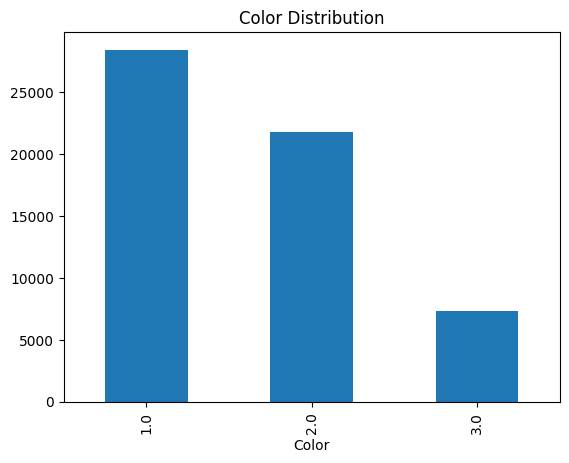

In [9]:
data['Color'].value_counts().plot(kind='bar', title='Color Distribution')

In [16]:
selected_columns = ['Person_ID', 'Color', 'DateOfBirth', 'ScoreText', 'Language']
filtered_data = data[selected_columns]
filtered_data.head()

,Person_ID,Color,DateOfBirth,ScoreText,Language
0,50844,2.0,12/05/92,SLow,English
1,50844,2.0,12/05/92,SLow,English
2,50844,2.0,12/05/92,SLow,English
3,50848,2.0,09/16/84,SLow,English
4,50848,2.0,09/16/84,SLow,English


In [17]:
# Compute the LP solution for the first instance
import os
import sys
import pickle
import numpy as np
# Get the absolute path of the src directory
current_dir = os.getcwd()
src_path = os.path.join(current_dir, '../src')
sys.path.append(src_path)
# Load the dataset from the file
import importlib
import setcover_dataset
from setcover_dataset import generate_setcover_dataset


In [36]:
#generate_subsets function
def get_instance(cleaned_dataset,frequency):
    """
    Returns a random sample of instances from the cleaned COMPAS dataset.
    """
    sampled_data = cleaned_dataset.sample(150)
    individuals = sampled_data.to_dict(orient='records')
    #getting available dates  - 6 months window
    start_date = datetime.strptime("04/01/2025", "%m/%d/%Y")
    end_date = datetime.strptime("10/01/2025", "%m/%d/%Y")
    total_days = (end_date - start_date).days + 1
    for individual in individuals:
        random_days = random.sample(range(total_days), 10)
        available_dates = [start_date + timedelta(days=added_days) for added_days in random_days]
        individual["AvailableDays"] = [date.strftime("%m/%d") for date in available_dates]
    
    #dividing age groups (18 - 25), (26 - 35), (36 - 45), (46+) 
    for individual in individuals:
        dob = datetime.strptime(individual["DateOfBirth"], "%m/%d/%y")
        if dob.year >= 2000:
            dob = dob.replace(year=dob.year - 100)
        study_date = datetime.strptime("01/01/2014", "%m/%d/%Y")
        age = study_date.year - dob.year - ((study_date.month, study_date.day) < (dob.month, dob.day))
        if age <= 25:
            individual["AgeGroup"] = 0
        elif age <= 35:
            individual["AgeGroup"] = 1
        elif age <= 45:
            individual["AgeGroup"] = 2
        else:
            individual["AgeGroup"] = 3
    # print("Number of individuals in each age group:",len(individuals))
    individuals_ = individuals.copy()
    # Partition individuals by AgeGroup
    agegroup_partitions = [[] for _ in range(4)]
    for i in range(len(individuals_)):
        agegroup_partitions[individuals_[i]["AgeGroup"]].append(i)
        
    element_colors = {i : individuals_[i]["Color"] for i in range(len(individuals_))}
    instance = generate_setcover_dataset(1,
                                len(individuals_),
                                5,
                                20,
                                10,
                                10,
                                frequency,
                                250,
                                weight_range=(5.0, 10.0),
                                color_distribution=(0.33, 0.33, 0.34),
                                random_seed=None,
                                element_colors=element_colors,
                                age_partitions=agegroup_partitions,
                                save_prefix=None
                            )
    return instance[0]


In [25]:
# Run a single dataset with frequency 3
from experiments import run_experiments


In [37]:
for freq in [3,5,8,10]:
    dataset= []
    for i in range(30):
        dataset.append(get_instance(filtered_data,freq))
    path = f'realworld_instances_frequency_small_{freq}.pkl'
    with open(path, 'wb') as f:
        pickle.dump(dataset, f)


In [38]:
with open('realworld_instances_frequency_small_3.pkl', 'rb') as f:
    instances = pickle.load(f)
results = run_experiments(instances,freq)

In [39]:
results.keys()

dict_keys(['time_fair_iter', 'time_inamdar', 'max_objectives', 'lp_objectives', 'fair_iter_objectives', 'inamdar_objectives', 'approximation_ratio_fair_iter', 'approximation_ratio_inamdar', 'coverage_reqs_fair_iter', 'coverage_reqs_inamdar'])

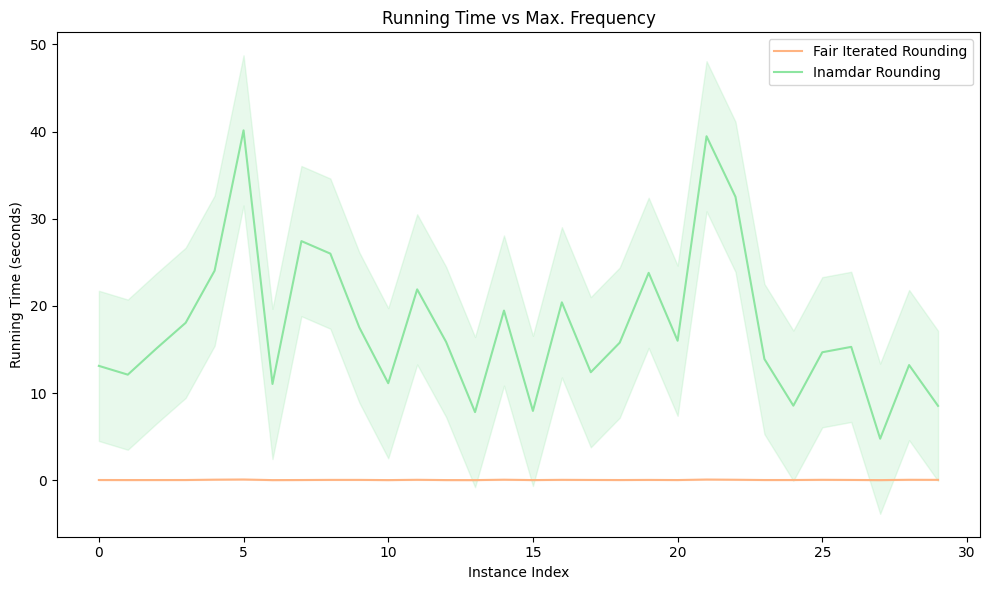

In [43]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

pastel_colors = sns.color_palette("pastel")
sns.set_palette(pastel_colors)

x = np.arange(len(results['lp_objectives']))

plt.figure(figsize=(10, 6))

# LP Relaxation
# lp = np.array(results['lp_objectives'])
# plt.plot(x, lp, label='LP Relaxation', color=pastel_colors[0])

# Fair Iter Objectives
fair_iter = np.array(results['time_fair_iter'])
plt.plot(x, fair_iter, label='Fair Iterated Rounding', color=pastel_colors[1])
plt.fill_between(x, fair_iter - fair_iter.std(), fair_iter + fair_iter.std(), color=pastel_colors[1], alpha=0.2)

# Inamdar Objectives
inamdar = np.array(results['time_inamdar'])
plt.plot(x, inamdar, label='Inamdar Rounding', color=pastel_colors[2])
plt.fill_between(x, inamdar - inamdar.std(), inamdar + inamdar.std(), color=pastel_colors[2], alpha=0.2)

plt.xlabel('Instance Index')
plt.ylabel('Running Time (seconds)')
plt.title('Running Time vs Max. Frequency')
plt.legend()
plt.tight_layout()
plt.show()

In [30]:
all_results = []
for freq in [3,5,8,10]:
    with open(f'realworld_instances_frequency_small_{freq}.pkl', 'rb') as f:
        instances = pickle.load(f)
    results = run_experiments(instances,freq)
    all_results.append(results)


In [32]:
all_results[3].keys()

dict_keys(['time_fair_iter', 'time_inamdar', 'max_objectives', 'lp_objectives', 'fair_iter_objectives', 'inamdar_objectives', 'approximation_ratio_fair_iter', 'approximation_ratio_inamdar', 'coverage_reqs_fair_iter', 'coverage_reqs_inamdar'])

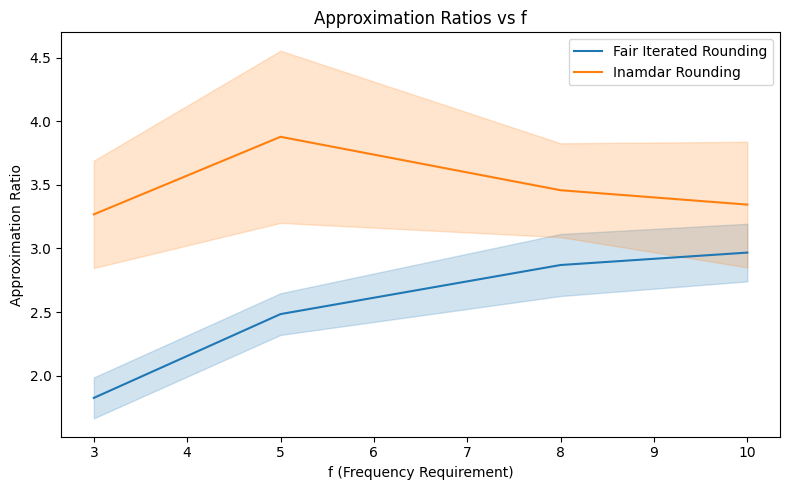

In [ ]:
import numpy as np

import matplotlib.pyplot as plt

# f values corresponding to all_results
f_values = [3, 5, 8, 10]

# Compute means and stds for both approximation ratios
fair_iter_means = [np.mean(r['approximation_ratio_fair_iter']) for r in all_results]
fair_iter_stds = [np.std(r['approximation_ratio_fair_iter']) for r in all_results]
inamdar_means = [np.mean(r['approximation_ratio_inamdar']) for r in all_results]
inamdar_stds = [np.std(r['approximation_ratio_inamdar']) for r in all_results]

plt.figure(figsize=(8, 5))

# Fair Iterated Rounding
plt.plot(f_values, fair_iter_means, label='Fair Iterated Rounding', color='tab:blue')
plt.fill_between(f_values, 
                 np.array(fair_iter_means) - np.array(fair_iter_stds), 
                 np.array(fair_iter_means) + np.array(fair_iter_stds), 
                 color='tab:blue', alpha=0.2)

# Inamdar Rounding
plt.plot(f_values, inamdar_means, label='Inamdar Rounding', color='tab:orange')
plt.fill_between(f_values, 
                 np.array(inamdar_means) - np.array(inamdar_stds), 
                 np.array(inamdar_means) + np.array(inamdar_stds), 
                 color='tab:orange', alpha=0.2)

plt.xlabel('f (Frequency Requirement)')
plt.ylabel('Approximation Ratio')
plt.title('Approximation Ratio vs Max. Frequency')
plt.legend()
plt.tight_layout()
plt.show()

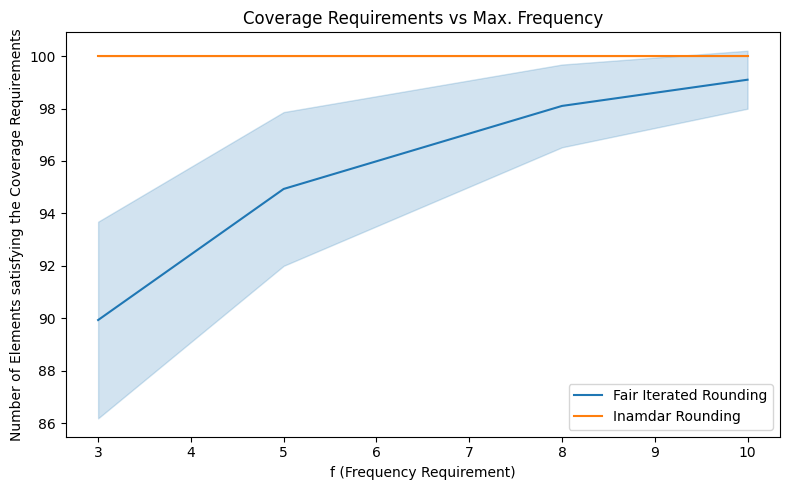

In [ ]:
import numpy as np

import matplotlib.pyplot as plt

# f values corresponding to all_results
f_values = [3, 5, 8, 10]

# Compute means and stds for both approximation ratios
fair_iter_means = [np.mean(r['coverage_reqs_fair_iter']) for r in all_results]
fair_iter_stds = [np.std(r['coverage_reqs_fair_iter']) for r in all_results]
inamdar_means = [np.mean(r['coverage_reqs_inamdar']) for r in all_results]
inamdar_stds = [np.std(r['coverage_reqs_inamdar']) for r in all_results]

plt.figure(figsize=(8, 5))

# Fair Iterated Rounding
plt.plot(f_values, fair_iter_means, label='Fair Iterated Rounding', color='tab:blue')
plt.fill_between(f_values, 
                 np.array(fair_iter_means) - np.array(fair_iter_stds), 
                 np.array(fair_iter_means) + np.array(fair_iter_stds), 
                 color='tab:blue', alpha=0.2)

# Inamdar Rounding
plt.plot(f_values, inamdar_means, label='Inamdar Rounding', color='tab:orange')
plt.fill_between(f_values, 
                 np.array(inamdar_means) - np.array(inamdar_stds), 
                 np.array(inamdar_means) + np.array(inamdar_stds), 
                 color='tab:orange', alpha=0.2)

plt.xlabel('f (Frequency Requirement)')
plt.ylabel('Number of Elements satisfying the Coverage Requirements')
plt.title('Coverage Requirements vs Max. Frequency')
plt.legend()
plt.tight_layout()
plt.show()

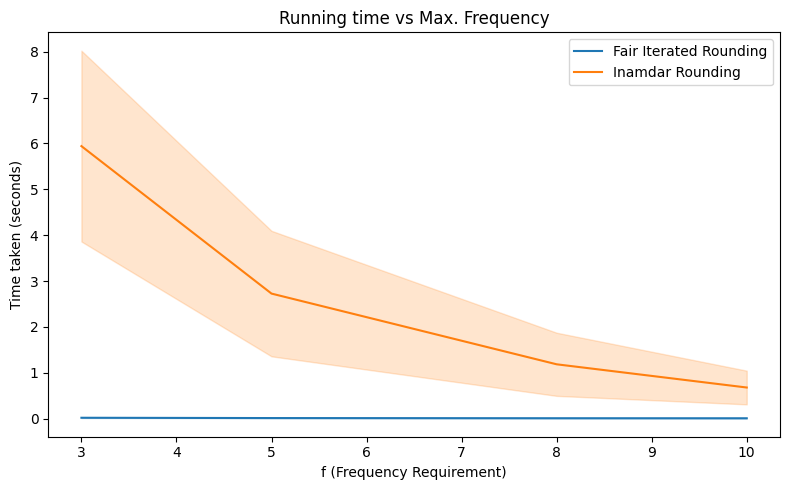

In [35]:
import numpy as np

import matplotlib.pyplot as plt

# f values corresponding to all_results
f_values = [3, 5, 8, 10]

# Compute means and stds for both approximation ratios
fair_iter_means = [np.mean(r['time_fair_iter']) for r in all_results]
fair_iter_stds = [np.std(r['time_fair_iter']) for r in all_results]
inamdar_means = [np.mean(r['time_inamdar']) for r in all_results]
inamdar_stds = [np.std(r['time_inamdar']) for r in all_results]

plt.figure(figsize=(8, 5))

# Fair Iterated Rounding
plt.plot(f_values, fair_iter_means, label='Fair Iterated Rounding', color='tab:blue')
plt.fill_between(f_values, 
                 np.array(fair_iter_means) - np.array(fair_iter_stds), 
                 np.array(fair_iter_means) + np.array(fair_iter_stds), 
                 color='tab:blue', alpha=0.2)

# Inamdar Rounding
plt.plot(f_values, inamdar_means, label='Inamdar Rounding', color='tab:orange')
plt.fill_between(f_values, 
                 np.array(inamdar_means) - np.array(inamdar_stds), 
                 np.array(inamdar_means) + np.array(inamdar_stds), 
                 color='tab:orange', alpha=0.2)

plt.xlabel('f (Frequency Requirement)')
plt.ylabel('Time taken (seconds)')
plt.title('Running time vs Max. Frequency')
plt.legend()
plt.tight_layout()
plt.show()